Duración de la simulación:  6.525344371795654
74 errores, para un BER de 0.0002.


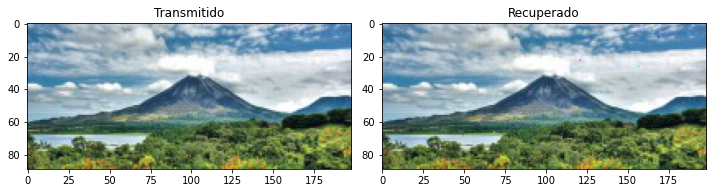

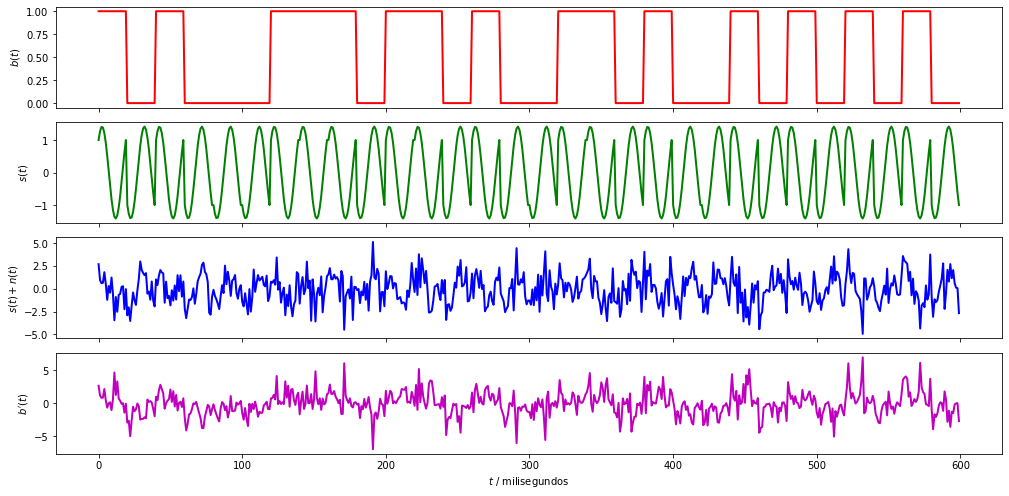

In [37]:
from PIL import Image
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import time


#PARTE 1

def fuente_info(imagen):

    img = Image.open(imagen)
    
    return np.array(img)

def rgb_a_bit(imagen):

    # dimensiones de la imagen
    x, y, z = imagen.shape
    
    # Número total de pixeles
    n_pixeles = x * y * z

    # Convertir la imagen a un vector unidimensional de n_pixeles
    pixeles = np.reshape(imagen, n_pixeles)

    # Convertir los canales a base 2
    bits = [format(pixel,'08b') for pixel in pixeles]
    bits_Rx = np.array(list(''.join(bits)))
    
    return bits_Rx.astype(int)

def modulador(bits, fc, mpp):

    # 1. Parámetros de la 'señal' de información (bits)
    N = len(bits) # Cantidad de bits

    # 2. Construyendo un periodo de la señal portadora c(t)
    Tc = 1 / fc  # periodo [s]
    t_periodo = np.linspace(0, Tc, mpp)
    sen = np.sin(2*np.pi*fc*t_periodo)
    cos = np.cos(2*np.pi*fc*t_periodo)
    portadora = sen + cos

    # 3. Inicializar la señal modulada s(t)
    t_simulacion = np.linspace(0, N*Tc, N*mpp) 
    senal_Tx = np.zeros(t_simulacion.shape)
    moduladora = np.zeros(t_simulacion.shape)  # señal de información
 
    # 4. Asignar las formas de onda según los bits (BPSK)
    for i, bit in enumerate(bits):
        if bit == 1:
            senal_Tx[i*mpp : (i+1)*mpp] = portadora
            moduladora[i*mpp : (i+1)*mpp] = 1
        else:
            senal_Tx[i*mpp : (i+1)*mpp] = portadora * -1
            moduladora[i*mpp : (i+1)*mpp] = 0
    
    # 5. Calcular la potencia promedio de la señal modulada
    Pm = (1 / (N*Tc)) * np.trapz(pow(senal_Tx, 2), t_simulacion)
    
    return senal_Tx, Pm, portadora, moduladora  

def canal_ruidoso(senal_Tx, Pm, SNR):
 
    # Potencia del ruido generado por el canal
    Pn = Pm / pow(10, SNR/10)

    # Generando ruido auditivo blanco gaussiano
    ruido = np.random.normal(0, np.sqrt(Pn), senal_Tx.shape)

    # Señal distorsionada por el canal ruidoso
    senal_Rx = senal_Tx + ruido

    return senal_Rx


def demodulador(senal_Rx, portadora, mpp):

    # Cantidad de muestras en senal_Rx
    M = len(senal_Rx)

    # Cantidad de bits en transmisión
    N = int(M / mpp)

    # Vector para bits obtenidos por la demodulación
    bits_Rx = np.zeros(N)

    # Vector para la señal demodulada
    senal_demodulada = np.zeros(M)

    # Energía de un período de la portadora
    Es = np.sum(portadora**2)

    # Demodulación
    for i in range(N):
        # Producto interno de dos funciones
        producto = senal_Rx[i*mpp : (i+1)*mpp] * portadora
        senal_demodulada[i*mpp : (i+1)*mpp] = producto
        Ep = np.sum(producto) 

        # Criterio de decisión por detección de energía
        if Ep > 0:
            bits_Rx[i] = 1
        else:
            bits_Rx[i] = 0

    return bits_Rx.astype(int), senal_demodulada

def bits_a_rgb(bits_Rx, dimensiones):
 
    # Cantidad de bits
    N = len(bits_Rx)

    # Se reconstruyen los canales RGB
    bits = np.split(bits_Rx, N / 8)

    # Se decofican los canales:
    canales = [int(''.join(map(str, canal)), 2) for canal in bits]
    pixeles = np.reshape(canales, dimensiones)

    return pixeles.astype(np.uint8)




# Parámetros
fc = 5000  # frecuencia de la portadora
mpp = 20   # muestras por periodo de la portadora
SNR = -2   # relación señal-a-ruido del canal

# Iniciar medición del tiempo de simulación
inicio = time.time()

# 1. Importar y convertir la imagen a trasmitir
imagen_Tx = fuente_info('arenal.jpg')
dimensiones = imagen_Tx.shape

# 2. Codificar los pixeles de la imagen
bits_Tx = rgb_a_bit(imagen_Tx)

# 3. Modular la cadena de bits usando el esquema BPSK
senal_Tx, Pm, portadora, moduladora = modulador(bits_Tx, fc, mpp)

# 4. Se transmite la señal modulada, por un canal ruidoso
senal_Rx = canal_ruidoso(senal_Tx, Pm, SNR)

# 5. Se desmodula la señal recibida del canal
bits_Rx, senal_demodulada = demodulador(senal_Rx, portadora, mpp)

# 6. Se visualiza la imagen recibida 
imagen_Rx = bits_a_rgb(bits_Rx, dimensiones)
Fig = plt.figure(figsize=(10,6))

# Cálculo del tiempo de simulación
print('Duración de la simulación: ', time.time() - inicio)

# 7. Calcular número de errores
errores = sum(abs(bits_Tx - bits_Rx))
BER = errores/len(bits_Tx)
print('{} errores, para un BER de {:0.4f}.'.format(errores, BER))

# Mostrar imagen transmitida
ax = Fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(imagen_Tx)
ax.set_title('Transmitido')

# Mostrar imagen recuperada
ax = Fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(imagen_Rx)
ax.set_title('Recuperado')
Fig.tight_layout()

plt.imshow(imagen_Rx)




# Visualizar el cambio entre las señales
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, sharex=True, figsize=(14, 7))

# La onda cuadrada moduladora (bits de entrada)
ax1.plot(moduladora[0:600], color='r', lw=2) 
ax1.set_ylabel('$b(t)$')

# La señal modulada por BPSK
ax2.plot(senal_Tx[0:600], color='g', lw=2) 
ax2.set_ylabel('$s(t)$')

# La señal modulada al dejar el canal
ax3.plot(senal_Rx[0:600], color='b', lw=2) 
ax3.set_ylabel('$s(t) + n(t)$')

# La señal demodulada
ax4.plot(senal_demodulada[0:600], color='m', lw=2) 
ax4.set_ylabel('$b^{\prime}(t)$')
ax4.set_xlabel('$t$ / milisegundos')
fig.tight_layout()
plt.show()



<ipython-input-35-d8a6c3163c59>:4: DeprecationWarning: Using scipy.fft as a function is deprecated and will be removed in SciPy 1.5.0, use scipy.fft.fft instead.
  senal_f = fft(senal_Tx)


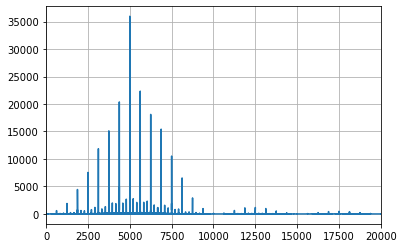

In [35]:
#PARTE 3

from scipy import fft

#Transformada
senal_f = fft(senal_Tx)

#muestras de la senal
Nm = len(senal_Tx)

#numero de simbolos (198 x 89 x 8 x 3)
Ns = Nm // mpp

#tiempo del simbolo = periodo de onda portadora
Tc = 1 / fc

#tiempo entre muestras (periodo de muestreo)
Tm = Tc / mpp

#tiempo de simulacion
T = Ns * Tc

#espacio de frecuencias
f = np.linspace(0.0, 1.0/(2.0 * Tm), Nm//2)

#grafica
plt.plot(f, 2.0/Nm * np.power(np.abs(senal_f[0:Nm//2]), 2))
plt.xlim(0, 20000)
plt.grid() 
plt.show()

         